# Previsão de Churn

  Modelo de classificação para mapear qual perfil de usuários tem mais chance de deixar uma plataforma de streaming.
  Compreender quem é o perfil que está aumentando o churn do seu negócio é essencial para tomar ações que reduzam essas perdas, seja alterando critérios na venda ou modificando o produto.


## Sobre os dados

Os dados fornecidos possuem informações sobre as contas dos clientes na plataforma de streaming, divididos entre contas Basic, Standard e Premium, onde cada uma oferece uma gama maior de serviços que a anterior.

<br>

---


Coluna | Descrição | Tipo
---|---|---
client_id | Código de identificação do cliente | *Int*
age | Idade do cliente | *Int*
gender | Gênero do cliente | *String*
region | Região de origem do cliente | *String*
subscription_days | Dias de assinatura ativa do cliente | *Int*
subscription_type | Tipo de conta | *String*
num_contents | Quantidade de conteúdos assistidos | *Int*
avg_rating | Avaliação média dos conteúdos da plataforma | *Int*
num_active_profiles | Número de perfis ativos na plataforma | *Int*
num_streaming_services | Quantidade de serviços de streaming que o cliente possui | *Int*
devices_connected | Quantidade de dispositivos conectados à conta | *Int*
churned | Se o cliente cancelou a conta ou não | *Int*


---
<br>



## Etapas

- Data undestand
- Data preparation
- Modeling
  - Desenvolvimento de um modelo de classificação que seja capaz de prever se o cliente irá cancelar o serviço ou não, levando em consideração o seu perfil no streaming;
  - Teste de mais de um tipo de modelo para encontrar o que possuir a melhor performance em comparação com um baseline (Tunning).


## Data Understanding

Análise exploratória de dados (EDA)

In [ ]:
#instalar bibliotecas
%%capture
%pip install plotly


In [ ]:
# importar bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px

from sklearn.preprocessing import LabelEncoder, scale, StandardScaler, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [ ]:
# carregar dataset

DATA = pd.read_csv('../data/streaming_churn.csv', encoding='latin1')
df = DATA
df

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f
...,...,...,...,...,...,...,...,...,...,...
77879,45.0,Male,NaN,NaN,Basic,NaN,5,2.20,0.0,6b51fe0d-d4a1-41ed-a55c-d05f5c961e3c
77880,47.0,Female,6176.0,NaN,Premium,NaN,2,4.54,0.0,59d70167-6be0-474c-b71e-14153205b44f
77881,64.0,Female,NaN,5.0,Premium,NaN,1,4.34,1.0,a7d5ed26-78a4-4e70-bd04-0fec883e56aa
77882,58.0,Male,1314.0,5.0,Standard,NaN,4,NaN,0.0,472e9e70-87ca-4c5e-bfee-fa9f42b54f51


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platform        56464 non-null  float64
 3   Devices_connected       52696 non-null  float64
 4   Subscription_type       52663 non-null  object 
 5   Num_streaming_services  9572 non-null   float64
 6   Num_active_profiles     77884 non-null  int64  
 7   Avg_rating              60614 non-null  float64
 8   Churned                 61148 non-null  float64
 9   User_id                 77884 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.9+ MB


Os valores estão em tipos diferentes daqueles apresentados na tabela da documentação dos Steakholders. Mais adiante preciso alterá-los.

In [ ]:
df.isna().sum()

Age                       11277
Gender                    14516
Time_on_platform          21420
Devices_connected         25188
Subscription_type         25221
Num_streaming_services    68312
Num_active_profiles           0
Avg_rating                17270
Churned                   16736
User_id                       0
dtype: int64

In [ ]:
df.describe()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
count,66607.000000,56464.000000,52696.000000,9572.000000,77884.000000,60614.000000,61148.000000
mean,43.511072,4385.848505,2.995370,2.496239,3.002273,3.002252,0.243066
std,15.043158,2526.580859,1.414072,1.120700,1.413235,1.154963,0.428938
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,30.000000,2196.000000,2.000000,1.000000,2.000000,1.990000,0.000000
50%,43.000000,4384.000000,3.000000,2.000000,3.000000,3.010000,0.000000
75%,57.000000,6573.000000,4.000000,4.000000,4.000000,4.000000,0.000000
max,69.000000,8759.000000,5.000000,4.000000,5.000000,5.000000,1.000000


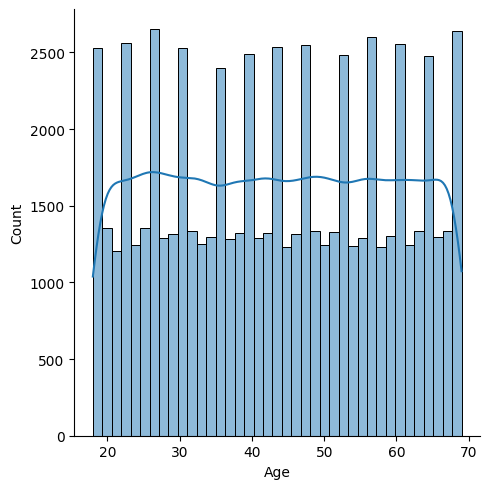

In [ ]:
sns.displot( data=df["Age"], kde=True )

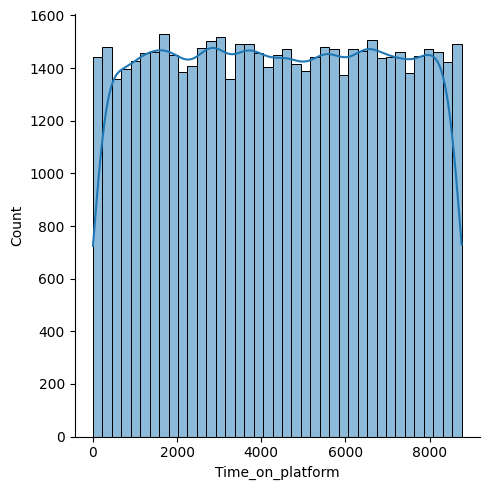

In [ ]:
sns.displot( data=df["Time_on_platform"], kde=True )

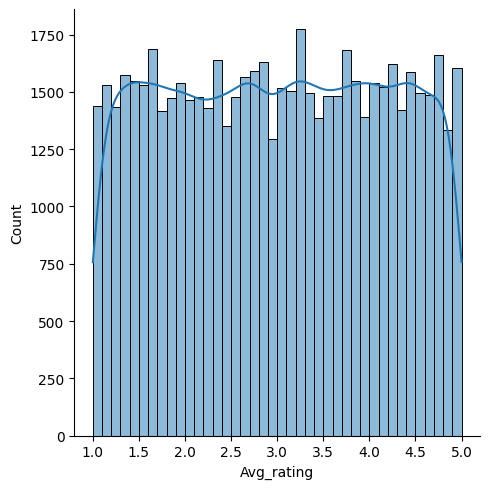

In [ ]:
sns.displot( data=df["Avg_rating"], kde=True )

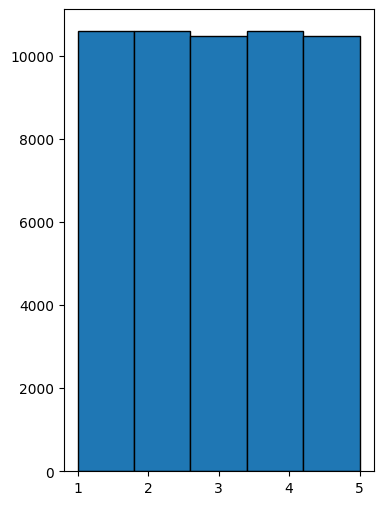

In [ ]:
# layout
fig, ax = plt.subplots(figsize = (4, 6))

# plot
ax.hist(df["Devices_connected"], bins=5, edgecolor="black");

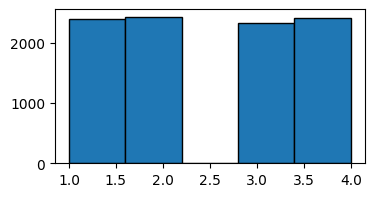

In [ ]:
# layout
fig, ax = plt.subplots(figsize = (4, 2))

# plot
ax.hist(df["Num_streaming_services"], bins=5, edgecolor="black");

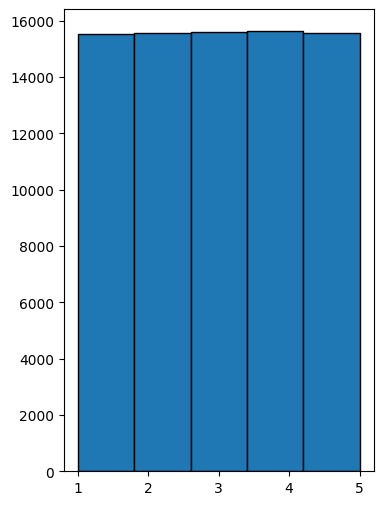

In [ ]:
# layout
fig, ax = plt.subplots(figsize = (4, 6))

# plot
ax.hist(df["Num_active_profiles"], bins=5, edgecolor="black");


## Data Preparation


Utilize as funções:

*   fillna()
*   dropna
*   replace
*   astype(int)




#### Substituir valores “NaN” por 0 Colunas → Time_on_platform, Num_streaming_services, Churned, Avg_rating, Devices_connected

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platform        56464 non-null  float64
 3   Devices_connected       52696 non-null  float64
 4   Subscription_type       52663 non-null  object 
 5   Num_streaming_services  9572 non-null   float64
 6   Num_active_profiles     77884 non-null  int64  
 7   Avg_rating              60614 non-null  float64
 8   Churned                 61148 non-null  float64
 9   User_id                 77884 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.9+ MB


In [ ]:
df.isna().sum()

Age                       11277
Gender                    14516
Time_on_platform          21420
Devices_connected         25188
Subscription_type         25221
Num_streaming_services    68312
Num_active_profiles           0
Avg_rating                17270
Churned                   16736
User_id                       0
dtype: int64

In [ ]:
columns_to_fill = ['Time_on_platform', 'Num_streaming_services', 'Churned', 'Avg_rating', 'Devices_connected']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

#### Dropar linhas nulas nas colunas Gender, Subscription_type e Age

In [ ]:
# Dropar linhas com valores nulos nas colunas Gender, Subscription_type e Age
columns_dropna = ['Gender', 'Subscription_type', 'Age']
df_cleaned = df.dropna(subset=columns_dropna)

In [ ]:
df_cleaned.isna().sum()

Age                       0
Gender                    0
Time_on_platform          0
Devices_connected         0
Subscription_type         0
Num_streaming_services    0
Num_active_profiles       0
Avg_rating                0
Churned                   0
User_id                   0
dtype: int64

#### Transformando valores churned 0 e 1 por No e Yes

In [ ]:
# Transformar valores 0 e 1 em 'No' e 'Yes' na coluna Churned
df_cleaned['Churned'] = df['Churned'].replace({0: 'No', 1: 'Yes'})

<ipython-input-18-502531857dd8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Churned'] = df['Churned'].replace({0: 'No', 1: 'Yes'})


In [ ]:
df_cleaned.head(2)

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,0.0,3,0.00,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,0.0,1,2.14,No,fe14b048-770b-4619-8ec6-485b0969ae31


In [ ]:
df_cleaned.groupby('Churned')['Churned'].count()

Churned
No     29459
Yes     7056
Name: Churned, dtype: int64

In [ ]:
churned_agg = df_cleaned.groupby("Churned")['User_id'].count().reset_index()
churned_agg = pd.DataFrame(churned_agg)
churned_agg

,Churned,User_id
0,No,29459
1,Yes,7056


In [ ]:
df_cleaned['Churned'].value_counts()

Churned
No     29459
Yes     7056
Name: count, dtype: int64

#### Transformando valores floats em valores inteiros

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36515 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     36515 non-null  float64
 1   Gender                  36515 non-null  object 
 2   Time_on_platform        36515 non-null  float64
 3   Devices_connected       36515 non-null  float64
 4   Subscription_type       36515 non-null  object 
 5   Num_streaming_services  36515 non-null  float64
 6   Num_active_profiles     36515 non-null  int64  
 7   Avg_rating              36515 non-null  float64
 8   Churned                 36515 non-null  object 
 9   User_id                 36515 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 3.1+ MB


In [ ]:
df_cleaned[['Age', 'Time_on_platform', 'Devices_connected', 'Num_streaming_services', 'Avg_rating']].isnull().sum()

Age                       0
Time_on_platform          0
Devices_connected         0
Num_streaming_services    0
Avg_rating                0
dtype: int64

In [ ]:
df_cleaned.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,0.0,3,0.00,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,0.0,1,2.14,No,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,Yes,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,0.0,5.0,Basic,0.0,2,0.00,No,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
5,54.0,Male,3024.0,2.0,Basic,0.0,1,0.00,No,a1df3a13-9255-4d00-8a9d-20565fefaab9


In [ ]:
# Converter as colunas float selecionadas para inteiros
df_cleaned['Avg_rating'] = df_cleaned['Avg_rating'].astype('int64')

<ipython-input-26-3f090d295eab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Avg_rating'] = df_cleaned['Avg_rating'].astype('int64')


In [ ]:
df_cleaned['Num_streaming_services'] = df_cleaned['Num_streaming_services'].astype('int64')

<ipython-input-27-9fe4c9cbea79>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Num_streaming_services'] = df_cleaned['Num_streaming_services'].astype('int64')


In [ ]:
df_cleaned['Devices_connected'] = df_cleaned['Devices_connected'].astype('int64')

<ipython-input-28-ac292f6cd2ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Devices_connected'] = df_cleaned['Devices_connected'].astype('int64')


In [ ]:
df_cleaned['Time_on_platform'] = df_cleaned['Time_on_platform'].astype('int64')

<ipython-input-29-b61555e6907f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Time_on_platform'] = df_cleaned['Time_on_platform'].astype('int64')


In [ ]:
df_cleaned['Age'] = df_cleaned['Age'].astype('int64')

<ipython-input-30-7d1a3a9f8e9b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Age'] = df_cleaned['Age'].astype('int64')


In [ ]:
# Verificar se há valores infinitos na coluna
inf_columns = df_cleaned[['Age']].apply(np.isinf).any()
print(inf_columns)

Age    False
dtype: bool


**Identificar valores infinitos**

```
inf_mask = df_cleaned[["Age"]].map(np.isinf)
print(inf_mask)
```

```
inf_mask = df_cleaned[["Age"]].map(np.isinf).sum()
print(inf_mask)
```

```
df_cleaned.Age.unique()
```

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36515 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     36515 non-null  int64 
 1   Gender                  36515 non-null  object
 2   Time_on_platform        36515 non-null  int64 
 3   Devices_connected       36515 non-null  int64 
 4   Subscription_type       36515 non-null  object
 5   Num_streaming_services  36515 non-null  int64 
 6   Num_active_profiles     36515 non-null  int64 
 7   Avg_rating              36515 non-null  int64 
 8   Churned                 36515 non-null  object
 9   User_id                 36515 non-null  object
dtypes: int64(6), object(4)
memory usage: 3.1+ MB


Caso houvesse a necessidade, poderia passar os seguintes comandos para remover valores infinitos:

<br>

- Dropar linhas com valores não finitos
```
df = df.dropna().replace([float('inf'), float('-inf')], 0)
```

- Selecionar apenas as colunas de tipo float
```
float_cols = df.select_dtypes(include=['float']).columns
```

- Converter as colunas float selecionadas para inteiros, com arredondamento
```
df[float_cols] = df[float_cols].round().astype(int)
```

In [ ]:
# Renomeando o dataset para seguir na etapa de modeling
streaming = df_cleaned
streaming

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49,Male,4700,3,Basic,0,3,0,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69,Female,6107,2,Standard,0,1,2,No,fe14b048-770b-4619-8ec6-485b0969ae31
2,44,Male,6374,3,Premium,1,1,1,Yes,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26,Male,0,5,Basic,0,2,0,No,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
5,54,Male,3024,2,Basic,0,1,0,No,a1df3a13-9255-4d00-8a9d-20565fefaab9
...,...,...,...,...,...,...,...,...,...,...
77879,45,Male,0,0,Basic,0,5,2,No,6b51fe0d-d4a1-41ed-a55c-d05f5c961e3c
77880,47,Female,6176,0,Premium,0,2,4,No,59d70167-6be0-474c-b71e-14153205b44f
77881,64,Female,0,5,Premium,0,1,4,Yes,a7d5ed26-78a4-4e70-bd04-0fec883e56aa
77882,58,Male,1314,5,Standard,0,4,0,No,472e9e70-87ca-4c5e-bfee-fa9f42b54f51


## Modeling

### Logistic Regression

Utilize as funções:

- LabelEncoder
- .fit,
- .transform
- get_dummies
- MinMaxScaler
- train_test_split
- predict
- assign
- ConfusionMatrixDisplay




In [ ]:
streaming.columns

Index(['Age', 'Gender', 'Time_on_platform', 'Devices_connected',
       'Subscription_type', 'Num_streaming_services', 'Num_active_profiles',
       'Avg_rating', 'Churned', 'User_id'],
      dtype='object')

In [ ]:
# X and y definition
X = streaming[['Age', 'Gender', 'Time_on_platform', 'Devices_connected',
       'Subscription_type', 'Num_streaming_services', 'Num_active_profiles',
       'Avg_rating']]
y = streaming[['Churned']]

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36515 entries, 0 to 77883
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     36515 non-null  int64 
 1   Gender                  36515 non-null  object
 2   Time_on_platform        36515 non-null  int64 
 3   Devices_connected       36515 non-null  int64 
 4   Subscription_type       36515 non-null  object
 5   Num_streaming_services  36515 non-null  int64 
 6   Num_active_profiles     36515 non-null  int64 
 7   Avg_rating              36515 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 2.5+ MB


In [ ]:
# LabelEncoder
le = LabelEncoder()

le.fit(y.Churned)
y.Churned = le.transform(y.Churned)

<ipython-input-37-530bd65b35d5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.Churned = le.transform(y.Churned)


In [ ]:
y

,Churned
0,0
1,0
2,1
3,0
5,0
...,...
77879,0
77880,0
77881,1
77882,0


In [ ]:
# Get Dummies
X = pd.get_dummies(X)

In [ ]:
X.head()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Gender_Female,Gender_Male,Subscription_type_Basic,Subscription_type_Premium,Subscription_type_Standard
0,49,4700,3,0,3,0,False,True,True,False,False
1,69,6107,2,0,1,2,True,False,False,False,True
2,44,6374,3,1,1,1,False,True,False,True,False
3,26,0,5,0,2,0,False,True,True,False,False
5,54,3024,2,0,1,0,False,True,True,False,False


In [ ]:
# MinMaxScaler

mm = MinMaxScaler()

X = pd.DataFrame(mm.fit_transform(X))
X.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.607843,0.536591,0.6,0.00,0.50,0.0,0.0,1.0,1.0,0.0,0.0
1,1.000000,0.697226,0.4,0.00,0.00,0.4,1.0,0.0,0.0,0.0,1.0
2,0.509804,0.727709,0.6,0.25,0.00,0.2,0.0,1.0,0.0,1.0,0.0
3,0.156863,0.000000,1.0,0.00,0.25,0.0,0.0,1.0,1.0,0.0,0.0
4,0.705882,0.345245,0.4,0.00,0.00,0.0,0.0,1.0,1.0,0.0,0.0


StandardScaler
```
sc = StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test =  sc.transform(x_test)

```

In [ ]:
# train and test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# fitting
model = LogisticRegression(class_weight="balanced")


O modelo defautl estava dando erro nas predições. Por isso o parâmetro class_weight foi passado.

In [ ]:
# Modeling
lr = model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Predict

y_pred = lr.predict(x_test)

In [ ]:
# Assign
x_test.assign(churned=y_test).assign(predicted=y_pred)

,0,1,2,3,4,5,6,7,8,9,10,churned,predicted
11843,0.490196,0.706131,0.6,0.0,0.75,0.0,0.0,1.0,1.0,0.0,0.0,NaN,0
12678,0.980392,0.492636,0.6,0.0,0.75,0.8,1.0,0.0,0.0,0.0,1.0,NaN,1
35053,0.274510,0.097500,0.0,0.0,0.00,0.0,1.0,0.0,1.0,0.0,0.0,NaN,0
36421,0.411765,0.812992,0.0,0.0,0.25,0.0,1.0,0.0,0.0,0.0,1.0,NaN,0
19202,0.235294,0.303573,0.8,0.0,0.75,0.2,1.0,0.0,1.0,0.0,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19452,0.176471,0.000000,0.8,0.0,1.00,0.4,0.0,1.0,0.0,1.0,0.0,1.0,1
29606,0.470588,0.000000,0.0,0.0,0.50,0.2,1.0,0.0,1.0,0.0,0.0,NaN,0
35400,0.313725,0.715493,0.6,0.0,1.00,0.6,1.0,0.0,0.0,0.0,1.0,NaN,0
7825,0.941176,0.000000,0.2,0.0,0.50,0.4,0.0,1.0,1.0,0.0,0.0,NaN,1


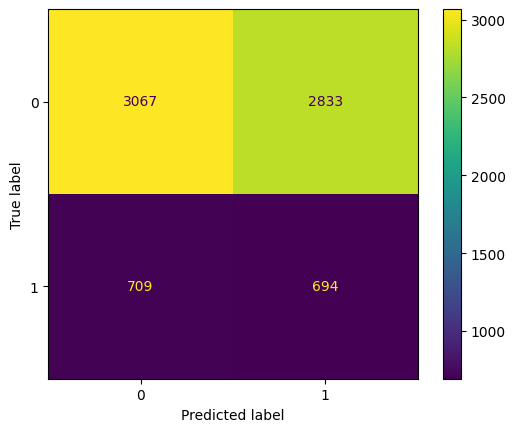

In [ ]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(lr, x_test, y_test, values_format='d')

Outra maneira de plotar a matriz de confusão (usando from_predictions)

```
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='d')
plt.show()
```

In [ ]:
# Print metrics

print(f"Acurácia (Treino): {accuracy_score(y_train, lr.predict(x_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, lr.predict(x_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, lr.predict(x_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, lr.predict(x_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, lr.predict(x_train))}")
print(f"Precision (Teste): {precision_score(y_test, lr.predict(x_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, lr.predict(x_train))}")
print(f"Recall (Teste): {recall_score(y_test, lr.predict(x_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, lr.predict(x_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, lr.predict(x_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, lr.predict_proba(x_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, lr.predict_proba(x_test)[:,1])}")

Acurácia (Treino): 0.5229700123237025
Acurácia (Teste): 0.514993838148706
Acurácia Balanceada (Treino): 0.5119215693023497
Acurácia Balanceada (Teste): 0.5072424103313722
Precision (Treino): 0.20135583441511612
Precision (Teste): 0.19676779132407146
Recall (Treino): 0.49389704581638066
Recall (Teste): 0.4946543121881682
F1-Score (Treino): 0.28608022951995493
F1-Score (Teste): 0.28154158215010144
ROCAUC (Treino): 0.5127236437911504
ROCAUC (Teste): 0.5064906918588497


### Random Forest


In [ ]:
# random forest classifier
rf =  RandomForestClassifier()

In [ ]:
# fitting

rf.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [ ]:
# predict
rf.predict(x_test)

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
# assign
x_test.assign(churned = y_test).assign(predicted = rf.predict(x_test))

,0,1,2,3,4,5,6,7,8,9,10,churned,predicted
11843,0.490196,0.706131,0.6,0.0,0.75,0.0,0.0,1.0,1.0,0.0,0.0,NaN,0
12678,0.980392,0.492636,0.6,0.0,0.75,0.8,1.0,0.0,0.0,0.0,1.0,NaN,0
35053,0.274510,0.097500,0.0,0.0,0.00,0.0,1.0,0.0,1.0,0.0,0.0,NaN,1
36421,0.411765,0.812992,0.0,0.0,0.25,0.0,1.0,0.0,0.0,0.0,1.0,NaN,1
19202,0.235294,0.303573,0.8,0.0,0.75,0.2,1.0,0.0,1.0,0.0,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19452,0.176471,0.000000,0.8,0.0,1.00,0.4,0.0,1.0,0.0,1.0,0.0,1.0,0
29606,0.470588,0.000000,0.0,0.0,0.50,0.2,1.0,0.0,1.0,0.0,0.0,NaN,0
35400,0.313725,0.715493,0.6,0.0,1.00,0.6,1.0,0.0,0.0,0.0,1.0,NaN,0
7825,0.941176,0.000000,0.2,0.0,0.50,0.4,0.0,1.0,1.0,0.0,0.0,NaN,0


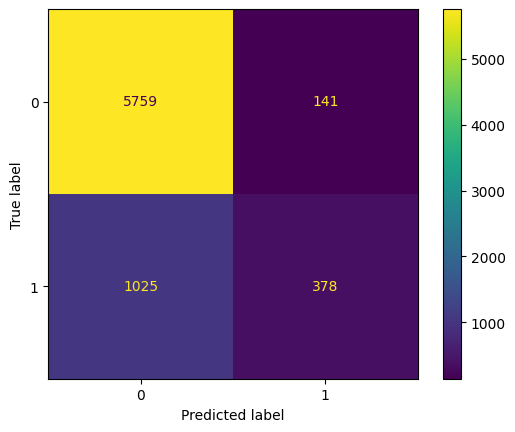

In [ ]:
# plot confusion matrix
cmDisplay = ConfusionMatrixDisplay.from_estimator(rf, x_test, y_test, values_format='d')

In [ ]:
# metrics rf

print(f"Acurácia (Treino): {accuracy_score(y_train, rf.predict(x_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, rf.predict(x_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, rf.predict(x_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, rf.predict(x_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, rf.predict(x_train))}")
print(f"Precision (Teste): {precision_score(y_test, rf.predict(x_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, rf.predict(x_train))}")
print(f"Recall (Teste): {recall_score(y_test, rf.predict(x_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, rf.predict(x_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, rf.predict(x_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, rf.predict_proba(x_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, rf.predict_proba(x_test)[:,1])}")

Acurácia (Treino): 0.9945227988497878
Acurácia (Teste): 0.8403395864713131
Acurácia Balanceada (Treino): 0.9888733606681178
Acurácia Balanceada (Teste): 0.6227621803157882
Precision (Treino): 0.9919398173025256
Precision (Teste): 0.7283236994219653
Recall (Treino): 0.9796568193879356
Recall (Teste): 0.2694226657163222
F1-Score (Treino): 0.9857600569597722
F1-Score (Teste): 0.3933402705515089
ROCAUC (Treino): 0.9997988722353408
ROCAUC (Teste): 0.6904475880981432


### Tunning

a. Realizar a montagem do grid search

b. Realizar o .fit do modelo

c. Realizar o Tunning

d. Realizar a modelagem

e. Plotar matrix confusão

f. Printar métricas

<br>

Dica: Utilize as funções *grid_search.best_estimator_.get_params(), fit, assign, ConfusionMatrixDisplay*.

#### Tunning Logistic Regression

In [ ]:
# parametros GridSearch lr

parameters_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200]
    }

grid_search_lr = GridSearchCV(lr, parameters_lr, cv=5, scoring='accuracy', n_jobs=-1)

    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [100, 200, 300],
    'tol': [1e-4, 1e-3, 1e-2],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]  # Usado apenas se penalty for 'elasticnet'

In [ ]:
# fitting GridSearch rf
grid_search_lr.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'max_iter': [100, 200],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

O grid_search_lr está demorando muito (mais que 25 min). É normal?

In [ ]:
grid_search_lr.best_estimator_.get_params()

{'C': 0.1,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# best estimators lr_tunned

lr_tunned = LogisticRegression(C = 0.1,
      class_weight = 'balanced',
      dual= False,
      fit_intercept= True,
      intercept_scaling= 1,
      l1_ratio= None,
      max_iter= 200,
      multi_class= 'auto',
      n_jobs= None,
      penalty= 'l1',
      random_state= None,
      solver='saga',
      tol= 0.0001,
      verbose= 0,
      warm_start= False)

In [ ]:
# fitting lr_tunned

lr_tunned.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.1, class_weight='balanced', max_iter=200, penalty='l1',
                   solver='saga')

In [ ]:
# assign lr_tunned

lr_tunned.predict(x_test)
x_test.assign(churned = y_test).assign(predicted = lr_tunned.predict(x_test))

,0,1,2,3,4,5,6,7,8,9,10,churned,predicted
11843,0.490196,0.706131,0.6,0.0,0.75,0.0,0.0,1.0,1.0,0.0,0.0,NaN,0
12678,0.980392,0.492636,0.6,0.0,0.75,0.8,1.0,0.0,0.0,0.0,1.0,NaN,1
35053,0.274510,0.097500,0.0,0.0,0.00,0.0,1.0,0.0,1.0,0.0,0.0,NaN,0
36421,0.411765,0.812992,0.0,0.0,0.25,0.0,1.0,0.0,0.0,0.0,1.0,NaN,0
19202,0.235294,0.303573,0.8,0.0,0.75,0.2,1.0,0.0,1.0,0.0,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19452,0.176471,0.000000,0.8,0.0,1.00,0.4,0.0,1.0,0.0,1.0,0.0,1.0,1
29606,0.470588,0.000000,0.0,0.0,0.50,0.2,1.0,0.0,1.0,0.0,0.0,NaN,0
35400,0.313725,0.715493,0.6,0.0,1.00,0.6,1.0,0.0,0.0,0.0,1.0,NaN,0
7825,0.941176,0.000000,0.2,0.0,0.50,0.4,0.0,1.0,1.0,0.0,0.0,NaN,1


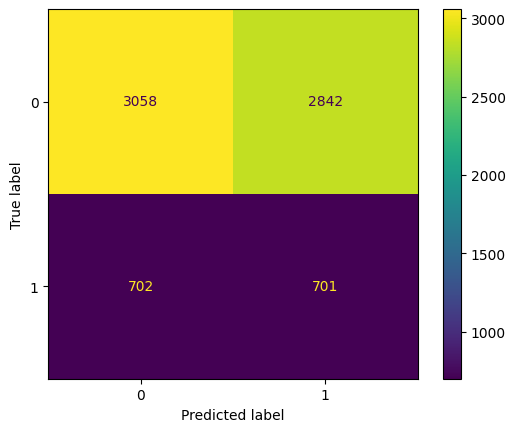

In [ ]:
# ConfusionMatrixDisplay rf_tunned

conf_matrix_Display = ConfusionMatrixDisplay.from_estimator(lr_tunned, x_test, y_test, values_format='d')

In [ ]:
# metrics lr_tunned

print(f"Acurácia (Treino): {accuracy_score(y_train, lr_tunned.predict(x_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, lr_tunned.predict(x_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, lr_tunned.predict(x_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, lr_tunned.predict(x_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, lr_tunned.predict(x_train))}")
print(f"Precision (Teste): {precision_score(y_test, lr_tunned.predict(x_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, lr_tunned.predict(x_train))}")
print(f"Recall (Teste): {recall_score(y_test, lr_tunned.predict(x_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, lr_tunned.predict(x_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, lr_tunned.predict(x_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, lr_tunned.predict_proba(x_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, lr_tunned.predict_proba(x_test)[:,1])}")

Acurácia (Treino): 0.5231754073668355
Acurácia (Teste): 0.5147199780911954
Acurácia Balanceada (Treino): 0.5125194862701618
Acurácia Balanceada (Teste): 0.5089743527791537
Precision (Treino): 0.20174426985728702
Precision (Teste): 0.19785492520462886
Recall (Treino): 0.4951353263753759
Recall (Teste): 0.49964362081254454
F1-Score (Treino): 0.28667998156398833
F1-Score (Teste): 0.2834613829357056
ROCAUC (Treino): 0.5127959111760142
ROCAUC (Teste): 0.506141319448639


#### Tunning Random Forest

In [ ]:
# parametros GridSearch rf
parameters_rf = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'n_estimators': [100, 300, 500]}

grid_search_rf = GridSearchCV(rf, parameters_rf, scoring='accuracy', cv=5, n_jobs=-1)

In [ ]:
# fitting GridSearch rf

grid_search_rf.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy')

In [ ]:
grid_search_rf.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# best estimators rf_tunned
rf_tunned =  RandomForestClassifier(bootstrap = True, ccp_alpha = 0.0,
                                     class_weight = None, criterion= 'gini',
                                     max_depth = 10, max_features= 'sqrt',
                                     max_leaf_nodes = None,
                                     max_samples = None,
                                     min_impurity_decrease = 0.0,
                                     min_samples_leaf = 1,
                                     min_samples_split = 2,
                                     min_weight_fraction_leaf = 0.0,
                                     n_estimators = 100, n_jobs = None,
                                     oob_score = False, random_state = None,
                                     verbose = 0, warm_start = False)
rf_tunned

RandomForestClassifier(max_depth=10)

In [ ]:
# fitting rf_tunned

rf_tunned.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=10)

In [ ]:
# assign rf_tunned

rf_tunned.predict(x_test)
x_test.assign(churned = y_test).assign(predicted = rf_tunned.predict(x_test))

,0,1,2,3,4,5,6,7,8,9,10,churned,predicted
11843,0.490196,0.706131,0.6,0.0,0.75,0.0,0.0,1.0,1.0,0.0,0.0,NaN,0
12678,0.980392,0.492636,0.6,0.0,0.75,0.8,1.0,0.0,0.0,0.0,1.0,NaN,0
35053,0.274510,0.097500,0.0,0.0,0.00,0.0,1.0,0.0,1.0,0.0,0.0,NaN,0
36421,0.411765,0.812992,0.0,0.0,0.25,0.0,1.0,0.0,0.0,0.0,1.0,NaN,0
19202,0.235294,0.303573,0.8,0.0,0.75,0.2,1.0,0.0,1.0,0.0,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19452,0.176471,0.000000,0.8,0.0,1.00,0.4,0.0,1.0,0.0,1.0,0.0,1.0,0
29606,0.470588,0.000000,0.0,0.0,0.50,0.2,1.0,0.0,1.0,0.0,0.0,NaN,0
35400,0.313725,0.715493,0.6,0.0,1.00,0.6,1.0,0.0,0.0,0.0,1.0,NaN,0
7825,0.941176,0.000000,0.2,0.0,0.50,0.4,0.0,1.0,1.0,0.0,0.0,NaN,0


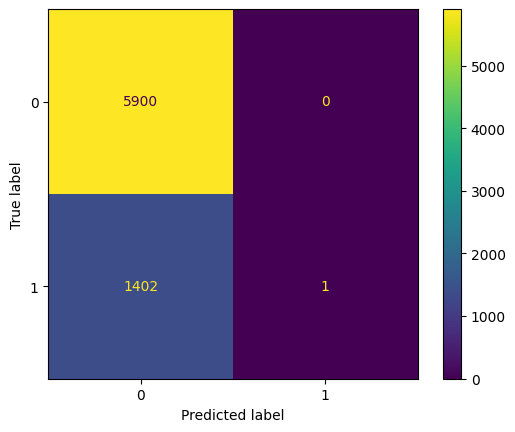

In [ ]:
# ConfusionMatrixDisplay rf_tunned

cmDisp = ConfusionMatrixDisplay.from_estimator(rf_tunned, x_test, y_test, values_format='d')

In [ ]:
# metrics rf_tunned

print(f"Acurácia (Treino): {accuracy_score(y_train, rf_tunned.predict(x_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, rf_tunned.predict(x_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, rf_tunned.predict(x_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, rf_tunned.predict(x_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, rf_tunned.predict(x_train))}")
print(f"Precision (Teste): {precision_score(y_test, rf_tunned.predict(x_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, rf_tunned.predict(x_train))}")
print(f"Recall (Teste): {recall_score(y_test, rf_tunned.predict(x_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, rf_tunned.predict(x_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, rf_tunned.predict(x_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, rf_tunned.predict_proba(x_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, rf_tunned.predict_proba(x_test)[:,1])}")

Acurácia (Treino): 0.8072367520197179
Acurácia (Teste): 0.808024099685061
Acurácia Balanceada (Treino): 0.5019458694498496
Acurácia Balanceada (Teste): 0.5003563791874555
Precision (Treino): 1.0
Precision (Teste): 1.0
Recall (Treino): 0.0038917388996992748
Recall (Teste): 0.0007127583749109052
F1-Score (Treino): 0.007753303964757709
F1-Score (Teste): 0.0014245014245014246
ROCAUC (Treino): 0.8793288826175311
ROCAUC (Teste): 0.5887870422943571


In [ ]:
# outra maneira de plotar as métricas - usando uma função

def metrics (x_train, x_test, y_train, y_test, model):
'''
Função para calcular as métricas de avaliação de um modelo de ML.
  Args:
    X_train: features de treino
    X_test: features de teste
    y_train: target de treino
    y_test: target de teste
    model: Modelo de Machine Learning
  Returns:
    Métricas de avaliação do modelo
'''
  for metric in [accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
    print(f'{metric.__name__} (Treino): {metric(y_train, model.predict(x_train))}')
    print(f'{metric.__name__} (Teste): {metric(y_test, model.predict(x_test))}')
    print('='*25)

  print(f"ROCAUC (Treino): {roc_auc_score(y_train, model.predict_proba(x_train)[:,1])}")
  print(f"ROCAUC (Teste): {roc_auc_score(y_test, model.predict_proba(x_test)[:,1])}")
  return None